# Manhattan Transfer: A Network Analysis

The following functions were implemented to create a graph representing the interactions among characters in John Dos Passos's novel *Manhattan Transfer* and calculate the related centrality measures. This notebook is part of the project **MANHATTAN TRANSFER: Novel analysis through computational methods**, available at https://alessandrafa.github.io/manhattan-transfer-dhdk/.

## Creating a graph using Python

Import some modules that will be used for the analysis: 
* ntlk: Natural Language Toolkit
* re: Regular Expressions
* networkX
* numpy
* pandas
* matplotlib

In [1]:
import nltk
import re
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

The following function allows to open and clean a .txt file. It replaces newlines with spaces and deletes all symbols; then it finds all **persName** and **said** elements that include a **ref** or **who** attribute with a reference to a character's ID. This is possible using the regular expression **<(persName|said) (ref|who)=\"#.+?/(persName|said)>**.
All tags are removed and replaced with the character's ID; finally, excess spaces are removed.
The function returns the clean version of the text, from which symbol, excess spaces and tags were removed, and a dictionary, containing characters' names as keys and number of occurrences as value.

In [14]:
def open_file_and_clean(filename):
    with open(filename, 'r') as file:
        data = file.read().replace('\n', ' ')

        data = re.sub(r'(\?|\.|,|!|;|-|\(|\))', '', data)
        char_id = []
        for i in re.finditer(r'<(persName|said) (ref|who)=\"#.+?/(persName|said)>', data):
            char_id.append(i)
        char_id = char_id[::-1]
        dict_chars = {}
        for i in char_id:
            char_name = re.search(r'(?<=(ref|who)="#)\w+(?=")', i[0])
            if char_name is None:
                continue
            data = data[:i.start()] + char_name[0] + ' ' + data[i.end()+1:]
            if char_name[0] in dict_chars.keys():
                dict_chars[char_name[0]] += 1               
            else:
                dict_chars[char_name[0]] = 1
        data = re.sub(r'<.+?>', ' ', data)
        data = re.sub(r'\s+', ' ', data)
    return data, dict_chars 

The next step is the removal of english stopwords from the text:

In [3]:
def wordTokens(text, stop_words):
    wtokens = nltk.word_tokenize(text.lower())
    wtokens = [w for w in wtokens if w not in stop_words]
    return wtokens

The result of the previous function is used to create a list of all tokens contained in the clean text:

In [4]:
def word_list(tok_text):
    w_list = []    
    for w in tok_text:
        w_list.append(w)
    regex = re.compile(r"[^\w?\—\w?a-zA-Z0-9\'\w+]|['']")
    w_list = [i for i in w_list if not regex.search(i)]
    return w_list

Then, we create a dictionary with characters' IDs as keys and arrays containing index positions in the text of each character.

In [5]:
def position_dict(chars, my_words):
    pos_dict = {}
    for i in chars.keys():
        k = []
        for ix, j in enumerate(my_words):
            if j == i.lower():
                k.append(ix)
        pos_dict[i] = np.array(k)
    return pos_dict

Starting from the dictionary of characters' positions in the text, we create a further dictionary containing links among characters given a distance threshold that is selected based on evaluations of results. In this analysis, we will use a **distance threshold of 15**. 
This functions returns a dictionary with characters' IDs as keys, each with a dictionary as value containing the IDs of the characters they interacted with as key, and the number of interactions as values.
The minimum number of interactions to include a character in another character's interactions dictionary is set to 3.


In [6]:
def links_dic_f(indices_dic, threshold):
    link_dic = {}
    for first_char, ind_arr1 in indices_dic.items():
        dic = {}
        for second_char, ind_arr2 in indices_dic.items():
            if first_char == second_char:
                continue
            matr = np.abs(ind_arr1[np.newaxis].T - ind_arr2) <= threshold
            s = np.sum(matr)
            if s > 3:
                dic[second_char] = s
        link_dic[first_char] = dic

    return link_dic

Characters without any interaction are removed from the characters list:

In [97]:
def remove_zero_link_chars(link_dic, chars_list):
    rem_set = set()
    for key in link_dic:
        if link_dic[key] == {}:
            rem_set.add(key)

    fin_list = [char for char in chars_list if char not in rem_set]
    return fin_list

Then, we create a list of tuples that represent the connection between characters (the edges of the graph):

In [60]:
def edge_tuples_f(link_dic):
    edges_tuples = []
    for key in link_dic:
        for item, value in link_dic[key].items():
            tup = (key, item, value)
            edges_tuples.append(tup)
    return edges_tuples

Once we have the graph, we can calculate the centrality measures, which are **Degree Centrality**, **Betweenness Centrality** and **Eigenvector Centrality**:

In [51]:
def calc_centralities(graph):
    
    dgc = nx.degree_centrality(graph)
    dgc = pd.DataFrame.from_dict(dgc, orient='index', columns=["DGC"])
    btc = nx.betweenness_centrality(graph)
    btc = pd.DataFrame.from_dict(btc, orient='index', columns=["BTC"])
    evc = nx.eigenvector_centrality(graph, weight='weight', max_iter=600)
    evc = pd.DataFrame.from_dict(evc, orient='index', columns=["EVC"])
    df = pd.concat([dgc, btc, evc], axis=1)
    return df

Finally, we plot these measures to obtain a graphic:


In [52]:
def plot_centrality(centr, df, title, n, col_list):
    
    ax = plt.subplot(1, 3, n)
    s = df.sort_values(centr, ascending=False)[:10]
    x = list(s[centr].index)[::-1]
    y = list(s[centr])[::-1]
    
    for i, v in enumerate(y):
        bars = plt.barh(x[i], v, color=col_list[n-1])
    
    plt.title(title, size=22)
    ax.get_xaxis().set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(axis='y', length = 0, labelsize=14)

## Results:

The following function creates a **Graph** and a **.gexf file** given an **input .txt file** and a list of **stopwords**:

In [101]:
def final_graph(filename, stopwords):
    my_text, my_chars=open_file_and_clean(filename)
    my_token_res=wordTokens(my_text,stopwords)
    my_words=word_list(my_token_res)
    my_pos=position_dict(my_chars, my_words)
    my_links_f=links_dic_f(my_pos, 15)
    my_node_chars=remove_zero_link_chars(my_links_f, my_pos.keys())
    my_edges_t = edge_tuples_f(my_links_f)
    G = nx.Graph()
    G.add_nodes_from(my_node_chars)
    G.add_weighted_edges_from(my_edges_t)
    outfile= "Graph_"+filename[:-4]+".gexf"
    nx.write_gexf(G, outfile)
    return G, filename[:-4]

This function creates a graphical representation of the **top 10 results** for each centrality measure:

In [ ]:
def centralities_function(G, name):
    my_centr=calc_centralities(G)
    my_centr.to_csv("Centr_"+name+".csv")
    figfile_centr="Centr_"+name+".png"
    col_list = ["peachpuff", "plum", "orange"]
    fig, ax = plt.subplots(1,3, figsize=(25, 10))
    plot_centrality("DGC", my_centr, 'Degree Centrality', 1, col_list)
    plot_centrality("BTC", my_centr, 'Betweeness Centrality', 2, col_list)
    plot_centrality("EVC", my_centr, 'Eigenvector Centrality', 3, col_list)
    plt.savefig(figfile_centr, dpi=300)
    return my_centr, figfile_centr

Finally, we implement the above functions to obtain our results. The library **nltk** provides a list of **english stopwords** that are used here to filter the input text. The results are calculated for the full text as well as for each individual section, to allow comparisons.

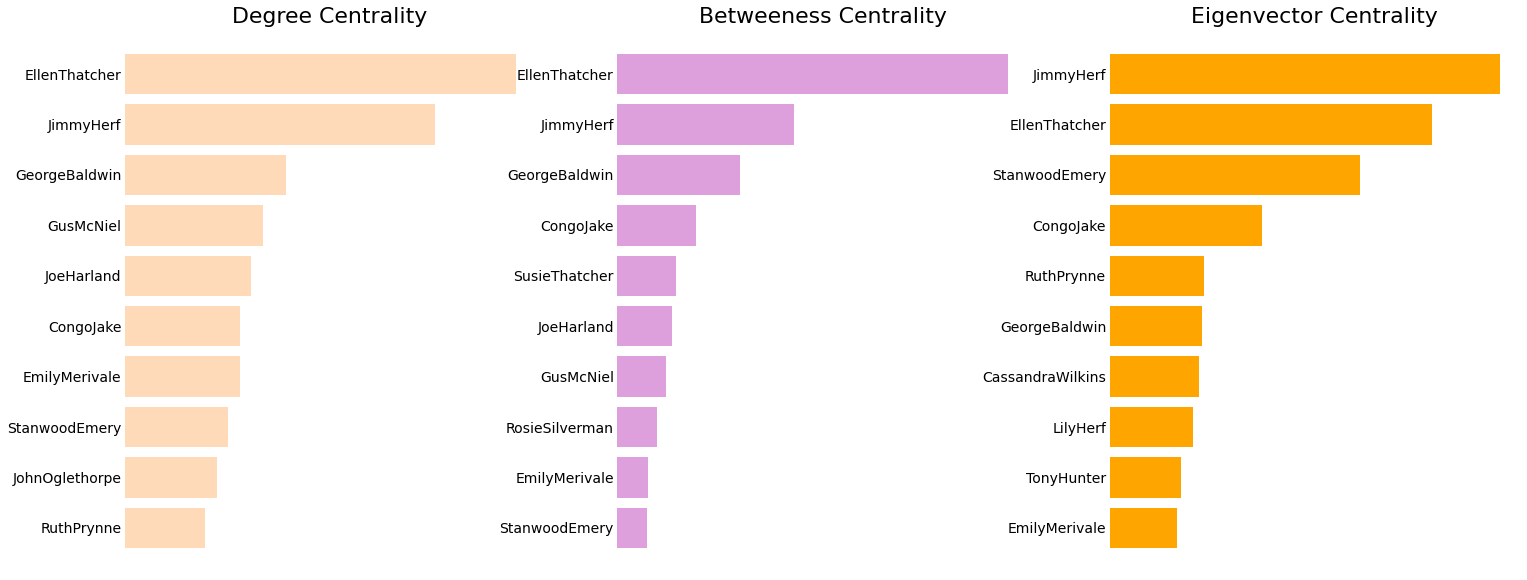

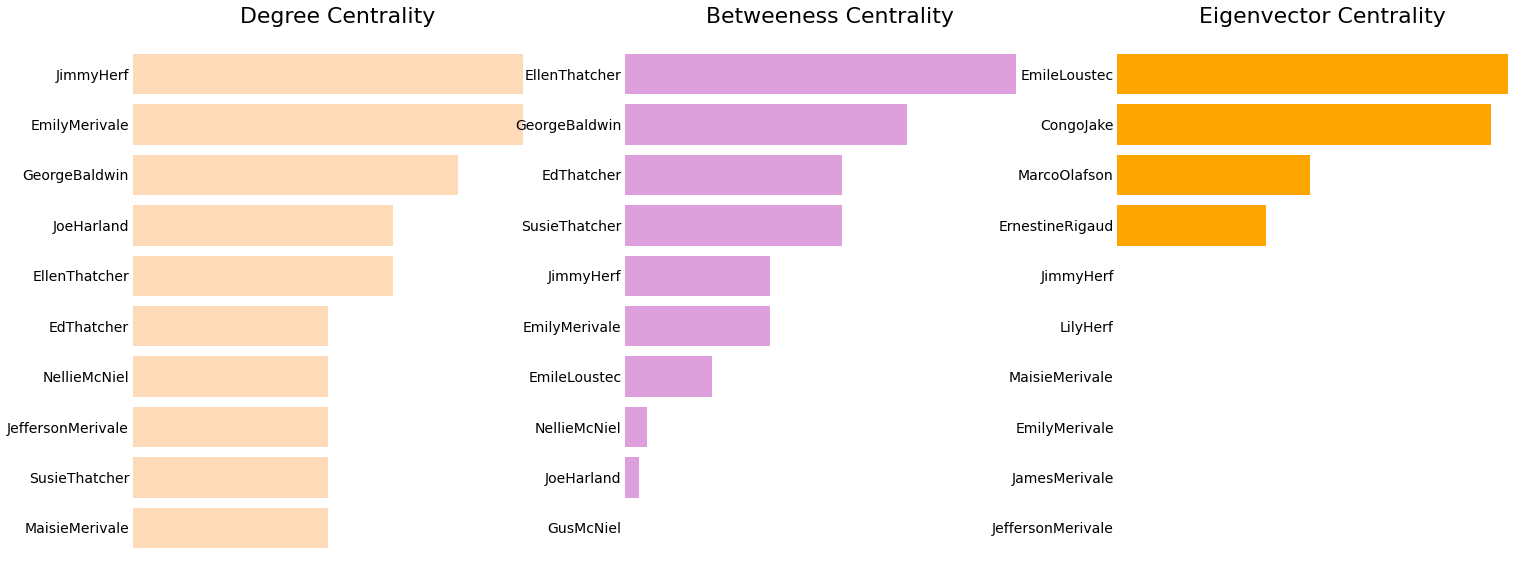

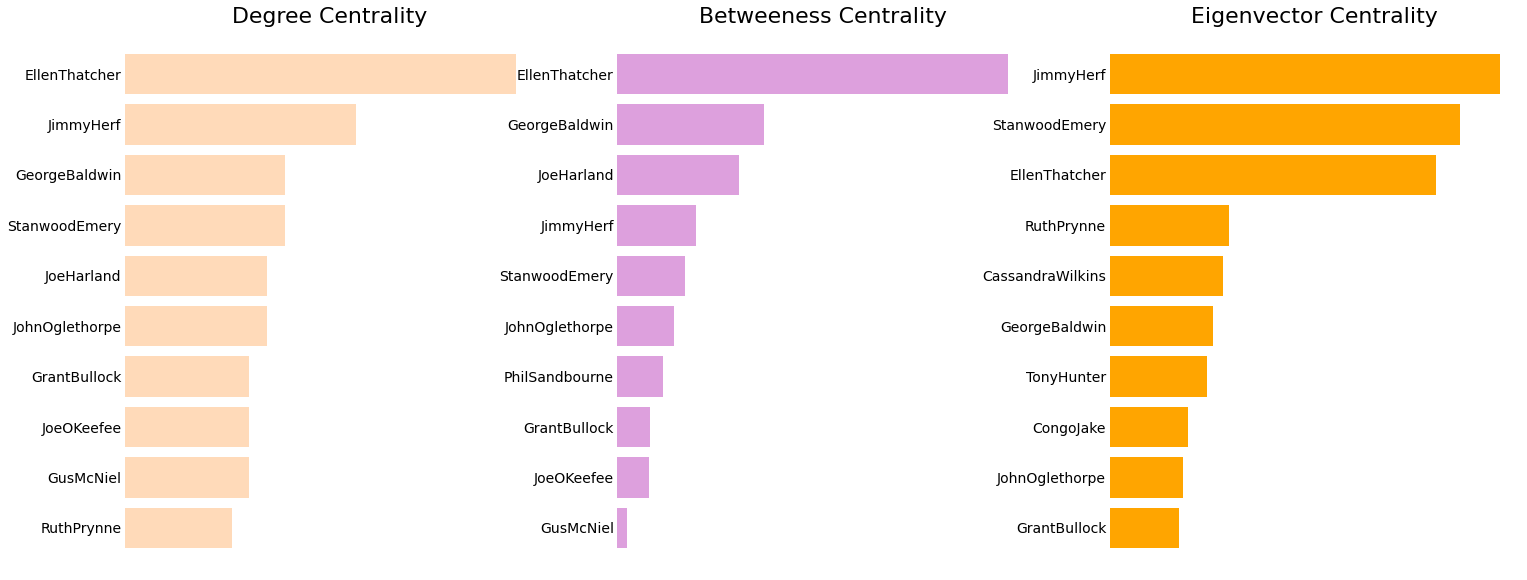

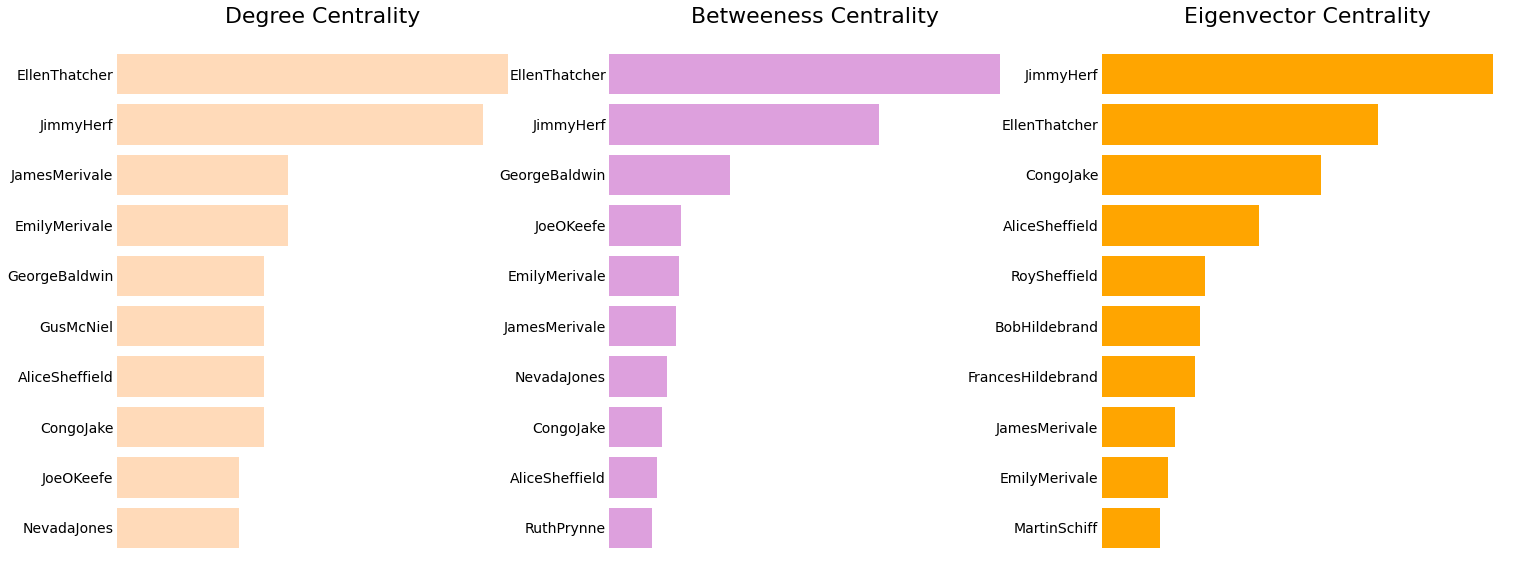

In [102]:
stopWords = nltk.corpus.stopwords.words('english')
Full_Graph, name_full=final_graph("MT_FULLTEXT.xml", stopWords)
Graph_1, name_1=final_graph("MT_SECTION1.xml", stopWords)
Graph_2, name_2=final_graph("MT_SECTION2.xml", stopWords)
Graph_3, name_3=final_graph("MT_SECTION3.xml", stopWords)
centr_full=centralities_function(Full_Graph, name_full)
centr_1=centralities_function(Graph_1, name_1)
centr_2=centralities_function(Graph_2, name_2)
centr_3=centralities_function(Graph_3, name_3)